# Exploration 13 주식 예측

### 엔씨소프트 주식

# 진행순서

1. 데이터 가져오기
2. 타임시리즈 데이터 생성
3. 결측치 처리 및 로그 변환
4. 시계열분석
5. ARIMA 모델 훈련 및 테스트
6. 예측 결과 

# 후기

하... 시간이 없어서 쫓기듯이 제출하지만      
꼭!!! 반드시!!!!!!!   
시계열데이터 예측은 정복하고 만다.    
나의 주식을 위하여★

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [7]:
# Time Series 생성
# [[YOUR CODE]]

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/036570.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-02-24    663000.0
2020-02-25    669000.0
2020-02-26    672000.0
2020-02-27    654000.0
2020-02-28    649000.0
Name: Close, dtype: float64

In [8]:
# 결측치 처리
# [[YOUR CODE]]
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [9]:
# 로그 변환
# [[YOUR CODE]]
ts_log = np.log(ts)

In [10]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

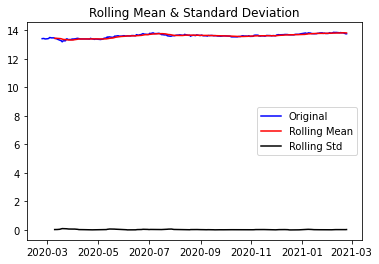

Results of Dickey-Fuller Test:
Test Statistic                  -1.604936
p-value                          0.481114
#Lags Used                       1.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


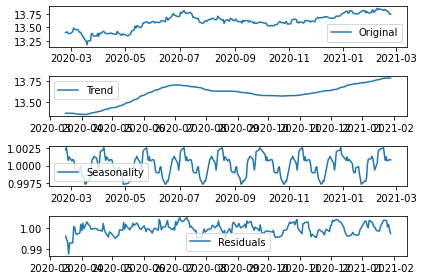

In [11]:
# 시계열 안정성 분석

# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
# [[YOUR CODE]]
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [12]:
# Residual 안정성 확인
# [[YOUR CODE]]
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -5.821721e+00
p-value                        4.167951e-07
#Lags Used                     0.000000e+00
Number of Observations Used    2.170000e+02
Critical Value (1%)           -3.460849e+00
Critical Value (5%)           -2.874953e+00
Critical Value (10%)          -2.573919e+00
dtype: float64


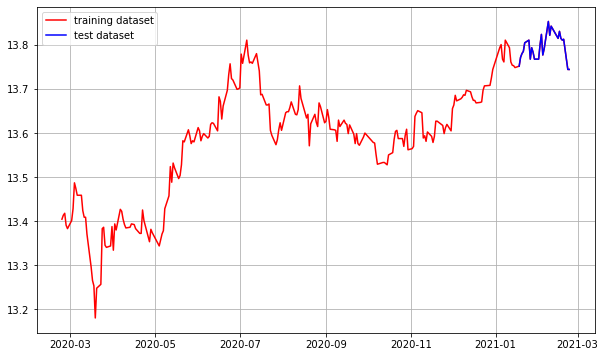

In [13]:
# 학습, 테스트 데이터셋 생성
# [[YOUR CODE]]
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

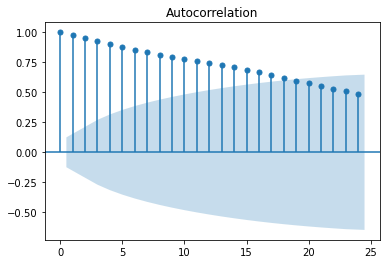

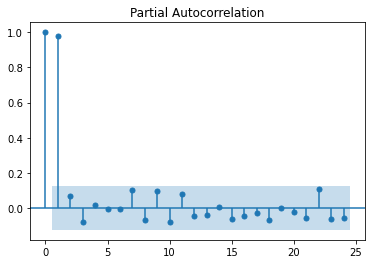

In [14]:
# 적정 ARIMA 모수 찾기

# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# [[YOUR CODE]]
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.703588e+01
p-value                        8.262122e-30
#Lags Used                     0.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.678879e+00
p-value                        1.522667e-11
#Lags Used                     1.200000e+01
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+00
Critical Value (10%)          -2.573424e+00
dtype: float64


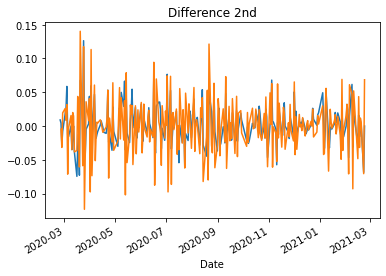

In [15]:
# 차분 안정성 확인 -> d 구하기
# [[YOUR CODE]]

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [16]:
# ARIMA 모델 훈련과 테스트

# 모델 빌드 앤 테스트
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
# [[YOUR CODE]]
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  222
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 478.594
Method:                       css-mle   S.D. of innovations              0.028
Date:                Tue, 02 Mar 2021   AIC                           -951.188
Time:                        13:30:18   BIC                           -940.980
Sample:                             1   HQIC                          -947.067
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0015      0.002      0.878      0.380      -0.002       0.005
ar.L1.D.Close    -0.0670      0.067     -1.002      0.316      -0.198       0.064
                                    Root

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been prov

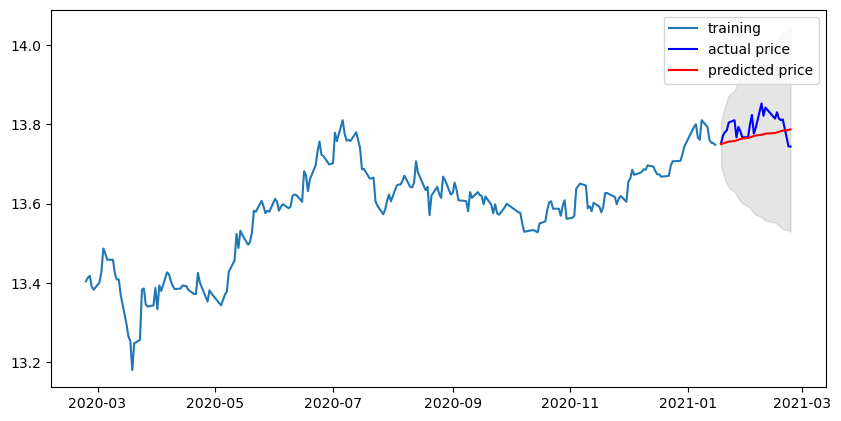

In [17]:
# 모델 테스트 및 플로팅
# Forecast : 결과가 fc에 담깁니다. 
# [[YOUR CODE]]
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
# [[YOUR CODE]]
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
# [[YOUR CODE]]
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [18]:
# 최종 예측 모델 정확도 측정(MAPE)
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# [[YOUR CODE]]
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

# [[YOUR CODE]]
mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

# [[YOUR CODE]]
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

# [[YOUR CODE]]
mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1380105125.842746
MAE:  31543.73455779828
RMSE:  37149.76616134678
MAPE: 3.18%
